In [1]:
# Required Libraries
import requests
import xml.etree.ElementTree as ET
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Fetch metadata for the Napa earthquake dataset
item_id = '5c1a392de4b0708288c2e9a5'
sb_json_url = f'https://www.sciencebase.gov/catalog/item/{item_id}?format=json'
response = requests.get(sb_json_url)

# Preview result
if response.status_code == 200:
    data = response.json()
    print("Title:", data.get("title"))
    print("Available Files:")
    for f in data.get("files", []):
        print("-", f.get("name"), "|", f.get("url"))
else:
    print("Request failed with status code:", response.status_code)


Title: Table of field observations of fault rupture and ground deformation features following the Mw 6.0 South Napa Earthquake of August 24, 2014
Available Files:
- Observations.txt | https://www.sciencebase.gov/catalog/file/get/5c1a392de4b0708288c2e9a5?f=__disk__6e%2Fa5%2F58%2F6ea558387733d699acc2767c24869017ff9564fd
- Observations.xml | https://www.sciencebase.gov/catalog/file/get/5c1a392de4b0708288c2e9a5?f=__disk__0c%2F4c%2F20%2F0c4c20f24410fc7126c45ac0ae8be3010f286d2d


In [3]:
# Download the XML file
xml_url = "https://www.sciencebase.gov/catalog/file/get/5c1a392de4b0708288c2e9a5?f=__disk__0c%2F4c%2F20%2F0c4c20f24410fc7126c45ac0ae8be3010f286d2d"
xml_filename = "Napa_Observations.xml"

# Download and save it
response = requests.get(xml_url)
if response.status_code == 200:
    with open(xml_filename, "wb") as f:
        f.write(response.content)
    print(f"XML file saved as: {xml_filename}")
else:
    print("Failed to download XML:", response.status_code)

XML file saved as: Napa_Observations.xml


In [4]:
# Load and parse the XML
tree = ET.parse("Napa_Observations.xml")
root = tree.getroot()

# Print root tag and a few top-level children to explore structure
print("Root tag:", root.tag)
print("\nFirst few children under root:")
for i, child in enumerate(root[:5]):
    print(f"[{i}] Tag: {child.tag}, Attributes: {child.attrib}")


Root tag: metadata

First few children under root:
[0] Tag: idinfo, Attributes: {}
[1] Tag: dataqual, Attributes: {}
[2] Tag: spdoinfo, Attributes: {}
[3] Tag: spref, Attributes: {}
[4] Tag: eainfo, Attributes: {}


In [5]:
eainfo = root.find("eainfo")

if eainfo is not None:
    print("eainfo found ✅")
else:
    print("No <eainfo> found ❌")

eainfo found ✅


In [6]:
detailed = eainfo.find("detailed")

if detailed is not None:
    for i, child in enumerate(detailed):
        print(f"[{i}] Tag: {child.tag}, Attributes: {child.attrib}")
else:
    print("No <detailed> section found inside <eainfo>.")


[0] Tag: enttyp, Attributes: {}
[1] Tag: attr, Attributes: {}
[2] Tag: attr, Attributes: {}
[3] Tag: attr, Attributes: {}
[4] Tag: attr, Attributes: {}
[5] Tag: attr, Attributes: {}
[6] Tag: attr, Attributes: {}
[7] Tag: attr, Attributes: {}
[8] Tag: attr, Attributes: {}
[9] Tag: attr, Attributes: {}
[10] Tag: attr, Attributes: {}
[11] Tag: attr, Attributes: {}
[12] Tag: attr, Attributes: {}
[13] Tag: attr, Attributes: {}
[14] Tag: attr, Attributes: {}
[15] Tag: attr, Attributes: {}
[16] Tag: attr, Attributes: {}
[17] Tag: attr, Attributes: {}
[18] Tag: attr, Attributes: {}
[19] Tag: attr, Attributes: {}
[20] Tag: attr, Attributes: {}
[21] Tag: attr, Attributes: {}


In [7]:
field_info = []

for attr in detailed.findall("attr"):
    label = attr.findtext("attrlabl", default="N/A")
    definition = attr.findtext("attrdef", default="No description")
    field_info.append((label.strip(), definition.strip()))

# Display the first few fields
for i, (label, definition) in enumerate(field_info):
    print(f"{i+1}. {label} — {definition}")

1. stnid — Identifier for the observation station. A station is assigned where descriptions, displacement measurements and (or) photographs have been obtained at a site at a given date and time by an observer or group of observers working together. Repeat observations at different times by the same observer or group of observers are assigned different stnids.
2. intid — Internal identifier. Used to link an observation record to associated records in the Photos table.
3. citation — If the data or photographs from this observation are published elsewhere, the original publication is cited here.
4. obs_date — Date of the observation as year, numerical month, and day of month.
5. latitude — Latitude coordinate of the station in decimal degrees, WGS84 datum. These values are derived either from the coordinate provided directly by the observer, or are digitized during compilation using airborne imagery and ground photographs to more accurately locate the station on the feature of interest. O

In [8]:
from collections import Counter

# Load the mapped CSV
import os
file_path = os.path.join(os.getcwd(), "napa_current_schema_20250708 (1).csv")
filtered_df = pd.read_csv(file_path)

# Define labeling rules
labeling_rules = {
    # Displacement-related
    r"\bnet slip\b|\bnet displacement\b": "Net_Slip_Preferred_cm",
    r"\bstrike[- ]?slip\b": "Slip_Sense",
    r"\bvertical displacement\b|\bvertical separation\b|\bupthrown\b": "Vertical_Separation_cm",
    r"\bhorizontal displacement\b|\bhorizontal separation\b": "Horizontal_Separation_cm",
    r"\bheave\b|\bextension\b|\bextensional\b": "Heave_cm",
    r"\bcompression\b|\bshortening\b": "comp_offset",

    # Azimuths & angles
    r"\bfault azimuth\b|\btrend\b|\bazimuth\b": "Local_Fault_Azimuth_Degrees",
    r"\bslip azimuth\b": "Slip_Azimuth",
    r"\bdip\b|\bfault dip\b": "Local_Fault_Dip",
    r"\bvm slip\b|\bvector magnitude\b": "VM_Slip_Azimuth",
    r"\btrending\b.*\b(north|south|east|west|NE|NW|SE|SW)\b": "Local_Fault_Azimuth_Degrees",

    # Fault/Feature types
    r"\bscarp\b": "Rupture_Expression",
    r"\bcrack\b|\bfissure\b|\bfractures?\b|\bcracking\b": "Rupture_Expression",
    r"\bmole tracks?\b": "Rupture_Expression",
    r"\bnormal fault\b|\bnormal component\b": "Feature_Origin",
    r"\bsurface rupture\b|\bfault trace\b": "Feature_Origin",
    r"\bdisturbed vegetation\b|\bwater[- ]filled depressions?\b": "Feature_Origin",

    # Width/height
    r"\brupture width\b|\bwidth of rupture\b": "Rupture_Width_m",
    r"\b(in|inch|inches)\b.*\bwide\b": "Horizontal_Separation_cm",
    r"\b(in|inch|inches)\b.*\bhigh\b": "Heave_cm",
    r"\bheight\b|\belevation\b": "Height_of_Material_m",

    # Direction
    r"\bfacing direction\b|\bscarp facing\b": "Scarp_Facing_Direction",

    # General observation info
    r"\bno (obvious|available)? offset\b": "Notes",
    r"\bpossibly old\b": "Notes",
    r"\babout\b.*\b(m|meters?)\b": "Notes",
    r"\bcompiler note\b|\bsource\b": "Notes",
    r"\bminor cracking\b|\bnot observed\b": "Notes",
}
# Update - add extended rules here using .update 
labeling_rules.update({
    r"\bslip\b.+?\bazimuth\b": "Slip_Azimuth",
    r"\bnet slip\b|\bestimated slip\b|\bnet movement\b": "Net_Slip_Preferred_cm",
    r"\bvm azimuth\b|\bvm slip\b": "VM_Slip_Azimuth",
    r"\bwidth\b.{0,10}rupture|\bwidth of rupture\b|\bwidth observed\b": "Rupture_Width_m",
    r"\bheight\b|\belevation\b|\bmaterial height\b": "Height_of_Material_m",
    r"\bscarp facing\b|\bfacing\b direction": "Scarp_Facing_Direction",
    
    # Bonus rules
    r"\bslip direction\b|\bslip az\b": "Slip_Azimuth",
    r"\bnet slip of\b|\boffset of\b \d+ ?(cm|m)": "Net_Slip_Preferred_cm"
})

# Compile regex patterns
compiled_rules = [(re.compile(pat, re.IGNORECASE), label) for pat, label in labeling_rules.items()]

# Split and label Notes text
notes_chunks = []
unmatched_chunks = []

for note in filtered_df['Notes']:
    for sentence in re.split(r'[.;]', str(note)):
        sentence = sentence.strip()
        if not sentence:
            continue

        matched_labels = []
        for pattern, field in compiled_rules:
            if pattern.search(sentence):
                matched_labels.append(field)

        if matched_labels:
            notes_chunks.append({"chunk": sentence, "labels": matched_labels})
        else:
            unmatched_chunks.append(sentence)

# Prepare multi-label format            
multi_label_df = pd.DataFrame(notes_chunks)

In [9]:
from collections import defaultdict
#Group by chunk and dedepulicate labels 
chunk_to_labels = defaultdict(set)

for entry in notes_chunks:
    chunk = entry["chunk"]
    for label in entry["labels"]:
        chunk_to_labels[chunk].add(label)

multi_label_data = [{"chunk": chunk, "labels": list(labels)} for chunk, labels in chunk_to_labels.items()]
multi_label_df = pd.DataFrame(multi_label_data)
multi_label_df.head()

,chunk,labels
0,Source: Napa 2014,[Notes]
1,Minor cracking,"[Rupture_Expression, Notes]"
2,no obvious offset,[Notes]
3,possibly old,[Notes]
4,"Compiler note: From photo, fracture is oriente...","[Rupture_Expression, Notes, Local_Fault_Azimut..."


In [10]:
# Filter rare labels 
from collections import Counter

label_counter = Counter(label for labels in multi_label_df["labels"] for label in labels)
valid_labels = {label for label, count in label_counter.items() if count >= 5}

filtered_multi_label_df = multi_label_df[
    multi_label_df["labels"].apply(lambda lbls: any(label in valid_labels for label in lbls))
].copy()

filtered_multi_label_df["labels"] = filtered_multi_label_df["labels"].apply(
    lambda lbls: [label for label in lbls if label in valid_labels]
)

C:\Users\harmo\OneDrive\Desktop\SCEC\SCEC_2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\harmo\OneDrive\Desktop\SCEC\SCEC_2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\harmo\OneDrive\Desktop\SCEC\SCEC_2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{

                             precision    recall  f1-score   support

             Feature_Origin       0.00      0.00      0.00         3
                   Heave_cm       1.00      0.08      0.15        12
   Horizontal_Separation_cm       0.00      0.00      0.00         2
Local_Fault_Azimuth_Degrees       1.00      0.81      0.89        31
            Local_Fault_Dip       0.00      0.00      0.00         0
                      Notes       1.00      0.10      0.18        10
         Rupture_Expression       0.82      0.99      0.89        68
               Slip_Azimuth       0.00      0.00      0.00         0
     Vertical_Separation_cm       0.00      0.00      0.00         4
                comp_offset       0.00      0.00      0.00         3

                  micro avg       0.86      0.71      0.78       133
                  macro avg       0.38      0.20      0.21       133
               weighted avg       0.82      0.71      0.69       133
                samples avg     

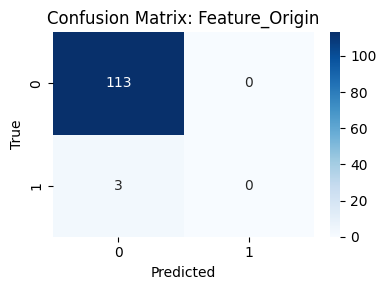

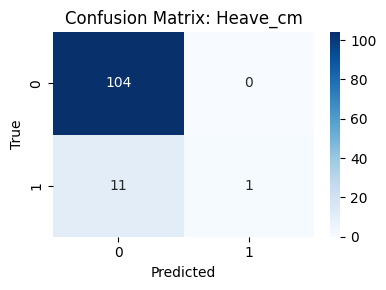

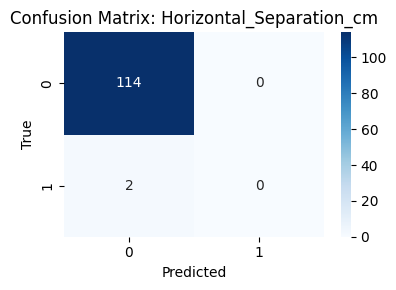

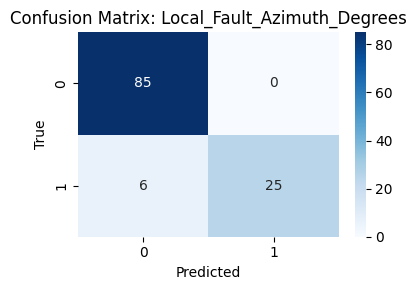

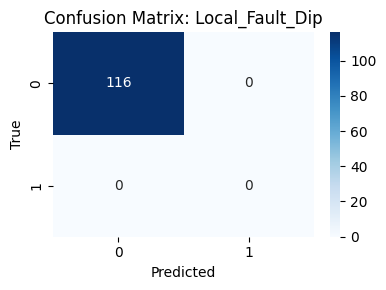

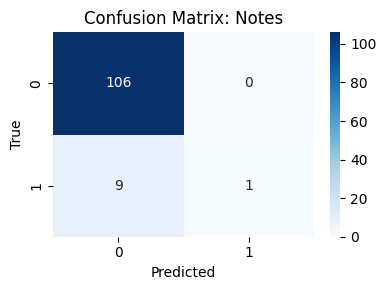

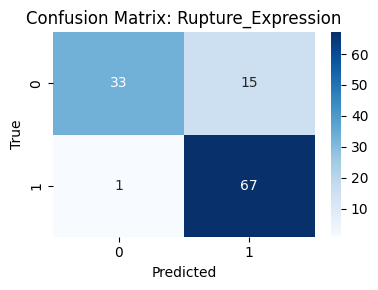

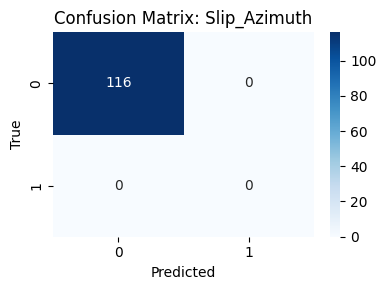

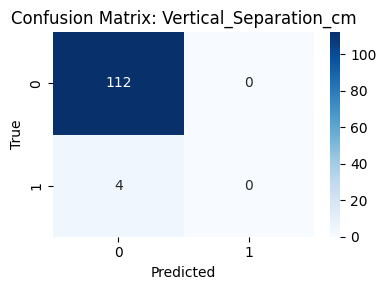

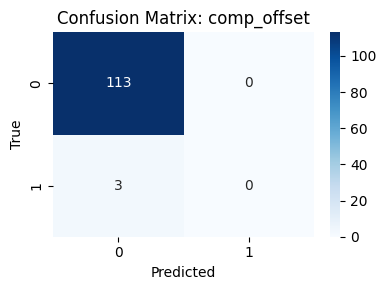

In [11]:
# Use MultiLabelBinarizer to convert to binary matrix format
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(multi_label_df['labels'])

# For text features
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
X = vectorizer.fit_transform(multi_label_df['chunk'])

# Train, Test, Split 
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train multi-label model
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
model.fit(X_train, Y_train)

# Evaluate 
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Y_pred = model.predict(X_test)

# Print classification report
print(classification_report(Y_test, Y_pred, target_names=mlb.classes_))

# Plot confusion matrix for each label
conf_matrices = multilabel_confusion_matrix(Y_test, Y_pred)

for i, (label, matrix) in enumerate(zip(mlb.classes_, conf_matrices)):
    plt.figure(figsize=(4, 3))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {label}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

=== Pipeline 1: Vectorize First ===
                             precision    recall  f1-score   support

             Feature_Origin       0.00      0.00      0.00         3
                   Heave_cm       1.00      0.08      0.15        12
   Horizontal_Separation_cm       0.00      0.00      0.00         2
Local_Fault_Azimuth_Degrees       1.00      0.81      0.89        31
            Local_Fault_Dip       0.00      0.00      0.00         0
                      Notes       1.00      0.10      0.18        10
         Rupture_Expression       0.82      0.99      0.89        68
               Slip_Azimuth       0.00      0.00      0.00         0
     Vertical_Separation_cm       0.00      0.00      0.00         4
                comp_offset       0.00      0.00      0.00         3

                  micro avg       0.86      0.71      0.78       133
                  macro avg       0.38      0.20      0.21       133
               weighted avg       0.82      0.71      0.69       

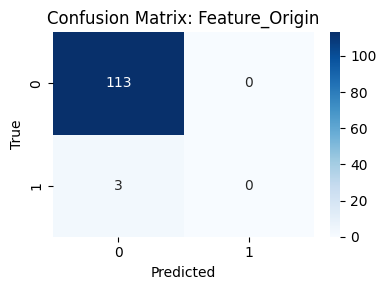

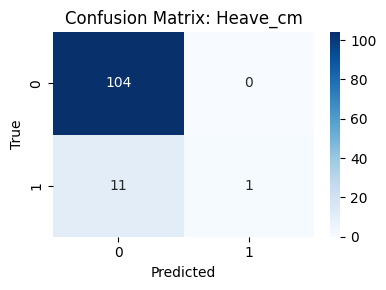

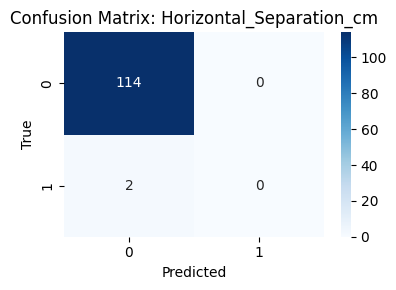

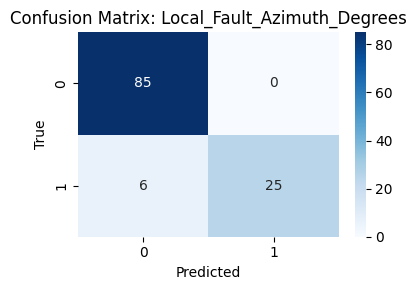

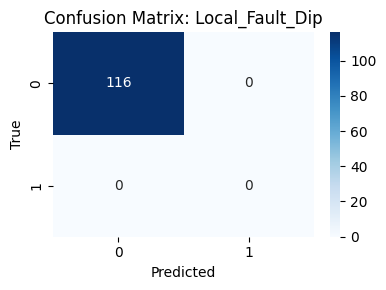

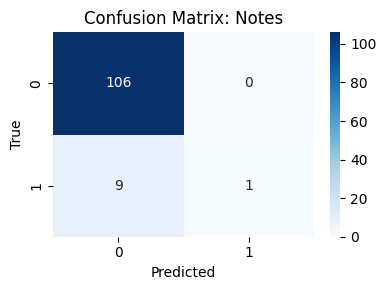

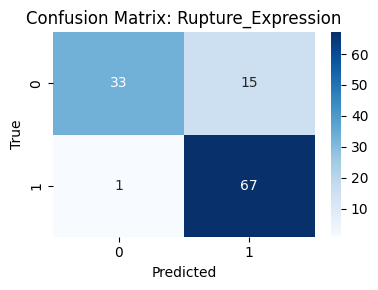

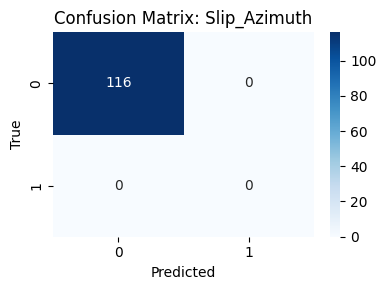

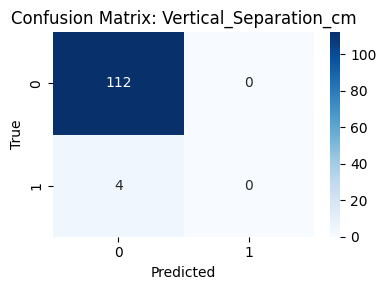

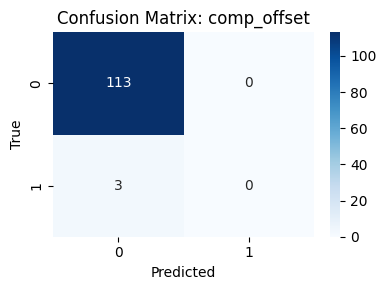

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare multilabel targets
mlb = MultiLabelBinarizer()
Y_mlb = mlb.fit_transform(multi_label_df['labels'])

# === Pipeline 1: Vectorize First, Then Split ===
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_mlb = vectorizer.fit_transform(multi_label_df['chunk'])

X_mlb_train, X_mlb_test, Y_mlb_train, Y_mlb_test = train_test_split(
    X_mlb, Y_mlb, test_size=0.2, random_state=42
)

model_mlb1 = OneVsRestClassifier(LogisticRegression(max_iter=1000))
model_mlb1.fit(X_mlb_train, Y_mlb_train)

Y_mlb_pred = model_mlb1.predict(X_mlb_test)
print("=== Pipeline 1: Vectorize First ===")
print(classification_report(Y_mlb_test, Y_mlb_pred, target_names=mlb.classes_, zero_division=0))

conf_matrices = multilabel_confusion_matrix(Y_mlb_test, Y_mlb_pred)
for i, (label, matrix) in enumerate(zip(mlb.classes_, conf_matrices)):
    plt.figure(figsize=(4, 3))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {label}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()


=== Pipeline 2: Split First ===
                             precision    recall  f1-score   support

             Feature_Origin       0.00      0.00      0.00         3
                   Heave_cm       1.00      0.17      0.29        12
   Horizontal_Separation_cm       0.00      0.00      0.00         2
Local_Fault_Azimuth_Degrees       1.00      0.84      0.91        31
            Local_Fault_Dip       0.00      0.00      0.00         0
                      Notes       1.00      0.20      0.33        10
         Rupture_Expression       0.83      1.00      0.91        68
               Slip_Azimuth       0.00      0.00      0.00         0
     Vertical_Separation_cm       0.00      0.00      0.00         4
                comp_offset       0.00      0.00      0.00         3

                  micro avg       0.88      0.74      0.80       133
                  macro avg       0.38      0.22      0.24       133
               weighted avg       0.82      0.74      0.73       133


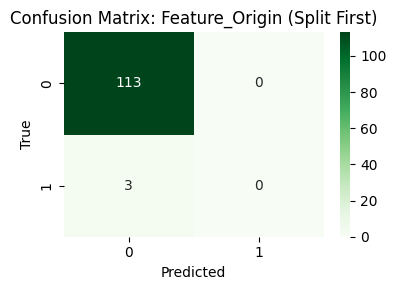

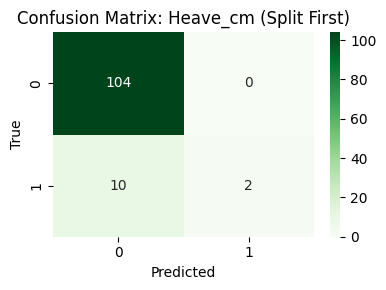

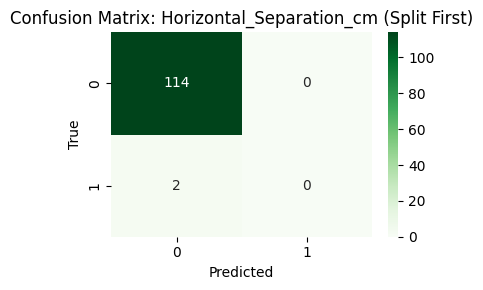

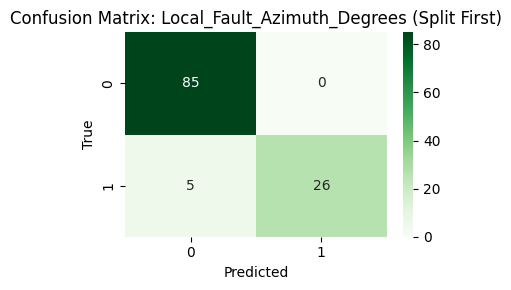

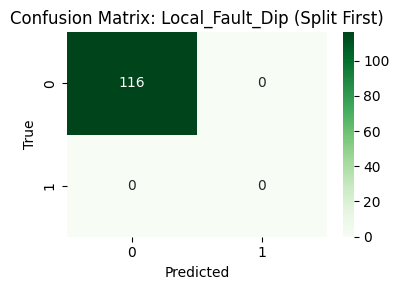

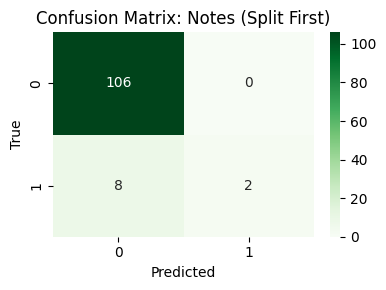

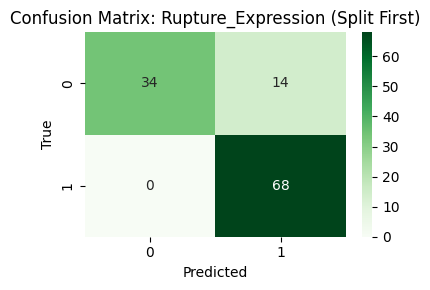

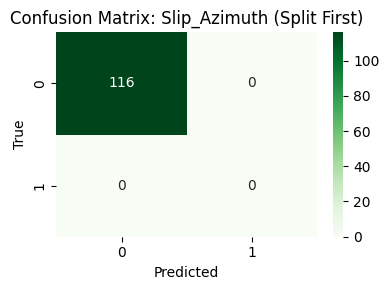

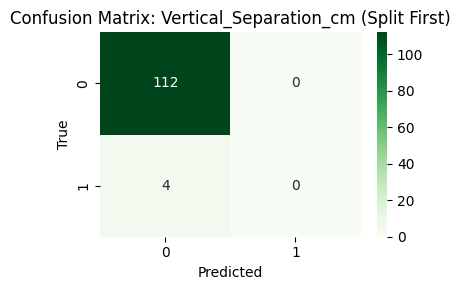

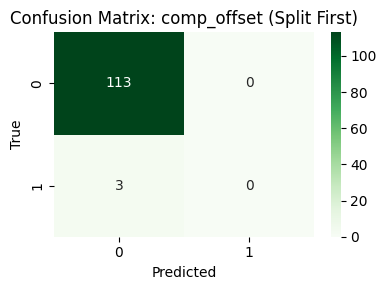

In [13]:
# === Pipeline 2: Split First, Then Vectorize ===

# Split BEFORE vectorizing
chunk_train_raw, chunk_test_raw, Y_mlb2_train, Y_mlb2_test = train_test_split(
    multi_label_df['chunk'], Y_mlb, test_size=0.2, random_state=42
)

# Vectorize after splitting
X_mlb2_train = vectorizer.fit_transform(chunk_train_raw)
X_mlb2_test = vectorizer.transform(chunk_test_raw)

model_mlb2 = OneVsRestClassifier(LogisticRegression(max_iter=1000))
model_mlb2.fit(X_mlb2_train, Y_mlb2_train)

Y_mlb2_pred = model_mlb2.predict(X_mlb2_test)
print("=== Pipeline 2: Split First ===")
print(classification_report(Y_mlb2_test, Y_mlb2_pred, target_names=mlb.classes_, zero_division=0))

conf_matrices2 = multilabel_confusion_matrix(Y_mlb2_test, Y_mlb2_pred)
for i, (label, matrix) in enumerate(zip(mlb.classes_, conf_matrices2)):
    plt.figure(figsize=(4, 3))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Greens')
    plt.title(f'Confusion Matrix: {label} (Split First)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

In [14]:
from sklearn.model_selection import train_test_split

# Split chunks and labels BEFORE vectorizing
chunk_train, chunk_test, Y_train, Y_test = train_test_split(
    multi_label_df['chunk'], Y, test_size=0.2, random_state=42
)

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(chunk_train)
X_test = vectorizer.transform(chunk_test)

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
model.fit(X_train, Y_train)

from sklearn.metrics import classification_report

Y_pred = model.predict(X_test)
print(classification_report(Y_test, Y_pred, target_names=mlb.classes_, zero_division=0))

                             precision    recall  f1-score   support

             Feature_Origin       0.00      0.00      0.00         3
                   Heave_cm       1.00      0.17      0.29        12
   Horizontal_Separation_cm       0.00      0.00      0.00         2
Local_Fault_Azimuth_Degrees       1.00      0.84      0.91        31
            Local_Fault_Dip       0.00      0.00      0.00         0
                      Notes       1.00      0.20      0.33        10
         Rupture_Expression       0.83      1.00      0.91        68
               Slip_Azimuth       0.00      0.00      0.00         0
     Vertical_Separation_cm       0.00      0.00      0.00         4
                comp_offset       0.00      0.00      0.00         3

                  micro avg       0.88      0.74      0.80       133
                  macro avg       0.38      0.22      0.24       133
               weighted avg       0.82      0.74      0.73       133
                samples avg     

In [15]:
from collections import Counter
print("Label counts:", Counter(labeled_chunks_df['label']))

print("Labels in training set:", sorted(set(y_train)))
print("Model classes:", sorted(model.classes_))
print("All desired fields:", sorted(labeling_rules.values()))


NameError: name 'labeled_chunks_df' is not defined

In [ ]:
unmatched_chunks = []

for note in filtered_df['Notes']:
    for sentence in re.split(r'[.;]', note):
        sentence = sentence.strip()
        if not sentence:
            continue
        matched = any(pattern.search(sentence) for pattern, _ in compiled_rules)
        if not matched:
            unmatched_chunks.append(sentence)

# Show a few examples of unmatched sentences
from collections import Counter
print("Unmatched sample:", unmatched_chunks[:10])
print("Total unmatched:", len(unmatched_chunks))


In [ ]:
from sklearn.utils import resample

# Combine into one DataFrame
df = labeled_chunks_df.copy()
min_count = df['label'].value_counts().min()

# Downsample each class
balanced_df = pd.concat([
    resample(group, replace=False, n_samples=min_count, random_state=42)
    for _, group in df.groupby('label')
])

# Redefine X and y
X = vectorizer.fit_transform(balanced_df['chunk'])
y = label_encoder.transform(balanced_df['label'])

In [17]:
from random import choice

# Augment examples manually (simple synthetic duplication)
rare_labels = ["Local_Fault_Dip", "Horizontal_Separation_cm", "comp_offset"]

# Create synthetic examples
augmented = []
for label in rare_labels:
    original_chunks = [row["chunk"] for row in notes_chunks if row["label"] == label]
    for i in range(10):  # Add 10 synthetic examples per rare label
        if original_chunks:
            sentence = choice(original_chunks)
            augmented.append({"chunk": sentence + " (duplicate)", "label": label})

# Add to original labeled data
notes_chunks += augmented
labeled_chunks_df = pd.DataFrame(notes_chunks)
print("Updated label distribution:", labeled_chunks_df['label'].value_counts())

KeyError: 'label'

In [18]:
import joblib
joblib.dump(model, "structured_field_classifier.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

NameError: name 'label_encoder' is not defined